## Sumário

[1. Introdução](#1.-Introdução)   
- [1.1 PCA vs LDA](#1.1-PCA-vs-LDA)
- [1.2 Aplicação](#1.2-Aplicação)
   
[2. Dataset](#2.-Dataset)
- [2.1 Importando o dataset](#2.1-Importando-o-dataset)  
- [2.2 Data Analysis](#2.2-Data-Analysis)   
- [2.3 Padronização dos dados](#2.3-Padronização-dos-dados)

[3. Principal Component Analysis](#3.-Principal-Component-Analysis)   
- [3.1 Autovetores e autovalores](#3.1-Autovetores-e-autovalores)
    - [3.1.1 Matriz de Covariância](#3.1.1-Matriz-de-Covariância)   
    - [3.1.2 Matriz de Correlação](#3.1.2-Matriz-de-Correlação)   
    - [3.1.3 Singular Vector Decomposition](#3.1.3-Singular-Vector-Decomposition)   
    - [3.1.4 Verificação dos autovetores e autovalores](#3.1.4-Verificação-dos-autovetores-e-autovalores)   
    - [3.1.5 Escolha dos autovetores e autovalores](#3.1.5-Escolha-dos-autovetores-e-autovalores)   
    - [3.1.6 Cálculo da Informação](#3.1.6-Cálculo-da-Informação)   

- [3.2 Matriz de Projeção](#3.2-Matriz-de-Projeção)   
- [3.3 Projeção no novo subespaço](#3.3-Projeção-no-novo-subespaço)

[4. PCA do scikit-learn](#4.-PCA-do-scikit-learn)

## 0. Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Database
from sklearn.datasets import load_iris

%matplotlib inline
pd.options.display.max_rows = 10

## 1. Introdução

**O objetivo principal do PCA é analisar os dados para identificar padrões visando reduzir a dimensionalidade dos dados com uma perda mínima de informação**. Uma possível aplicação seria o reconhecimento de padrões, onde queremos reduzir os custos computacionais e o erro da estimação de parâmetros pela redução da dimensionalidade do nosso espaço de atributos extraindo um subespaço que descreve os nosso dados "de forma satisfatória". **A redução de dimensionalidade se torna importante quando temos um número de atributos significativamente maior que o número de amostras de treinamento**.

Nós aplicamos o PCA para projetar todos os nossos dados (sem rótulos de classe) em um subespaço diferente, procurando encontrar os eixos com a máxima variância onde os dados são mais distribuídos. A questão principal é: **"Qual o subespaço que representa *bem* os nossos dados?"**.

**Primeiramente, calculamos os autovetores (componentes principais) dos nossos dados e organizamos em uma matriz de projeção. Cada autovetor (*eigenvector*) é associada a um autovalor (*eigenvalue*) que pode ser interpretado como o "tamanho" ou "magnitude" do autovetor correspondente**. Em geral, consideramos apenas o autovalores que tem uma magnitude significativamente maior que os outros e desconsideramos os autopares (autovetores-autovalores) que consideramos *menos informativos*. 

Se observamos que todos os autovalores tem uma magnitude similar, isso pode ser um bom indicador que nossos dados já estão em um *bom* subespaço. Por outro lado, **se alguns autovalores tem a magnitude muito maior que a dos outros, devemos escolher seus autovetores já que eles contém mais informação sobre a distribuição dos nossos dados**. Da mesma forma, autovalores próximos a zero são menos informativos e devemos desconsiderá-los na construção do nosso subespaço.

### 1.1 PCA vs LDA

Ambos PCA e LDA (*Linear Discrimant Analysis*) são métodos de transformação linear. Por uma lado, o PCA fornece as direções (autovetores ou componentes principais) que maximiza a variância dos dados, enquanto o LDA visa as direções que maximizam a separação (ou discriminação) entre classes diferentes. Maximizar a variância, no caso do PCA, também significa reduzir a perda de informação, que é representada pela soma das distâncias de projeção dos dados nos eixos dos componentes principais.

Enquanto o PCA projeta os dados em um subespaço diferente, o LDA tenta determinar um subespaço adequado para distinguir os padrões pertencentes as classes diferentes.

<img src="images/PCAvsLDA.png" width=600>

### 1.2 Aplicação

Em geral, a aplicação do PCA envolve os seguintes passos:
    
1. Padronização dos dados
2. Obtenção dos autovetores e autovalores através da:
    - Matriz de Covariância; ou
    - Matriz de Correlação; ou
    - *Singular Vector Decomposition*
3. Construção da matriz de projeção W a partir dos autovetores selecionados
4. Transformação dos dados originais X via W para obtenção do subespaço Y

Nesse tutorial, vamos utilizar o **Iris dataset**, já presente no scikit-learn. O Iris dataset contém dados de 150 flores divididas em 3 espécies diferentes (setosa, versicolor, virginica). Os dados são:

1. sepal lenght em cm
2. sepal width em cm
3. petal length em cm
4. petal width em cm

<img src="images/Iris-dataset.png" width=400>

## 2. Dataset

### 2.1 Importando o dataset

In [26]:
iris = load_iris()
print(iris.data.shape)
print(iris.target.shape)
print(iris.feature_names)
print(iris.target_names)

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
df['class'] = df['class'].map({0:iris.target_names[0], 1:iris.target_names[1], 2:iris.target_names[2]})
df

(150, 4)
(150,)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [27]:
# split the data table into data X and class labels Y
x = df.ix[:, 0:4].values
y = df.ix[:, 4].values
print(x.shape, y.shape)

(150, 4) (150,)


### 2.2 Data Analysis

In [28]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


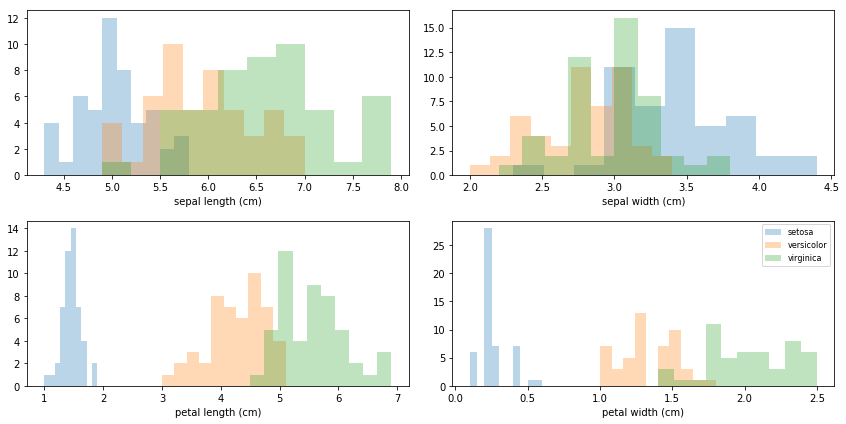

In [29]:
plt.figure(figsize=(12,6))
for f in range(4):
    plt.subplot(2, 2, f+1)
    for label in iris.target_names:
        plt.hist(x[y==label, f], label=label, bins=10, alpha=0.3)
        plt.xlabel(iris.feature_names[f])
plt.legend(loc='upper right', fancybox=True, fontsize=8)
plt.tight_layout()

### 2.3 Padronização dos dados

Primeiramente, iremos normalizar os dados à distribuição normal (média=0, desvio-padrão=1) utilizando a seguinte fórmula (onde cada atributo é normalizado individualmente):

$$std\_unit = \frac{x-\mu}{\sigma}$$

que pode ser utilizada através do módulo *StandardScaler*:

In [30]:
from sklearn.preprocessing import StandardScaler
x_std = StandardScaler().fit_transform(x)
print(x.shape)

(150, 4)


## 3. Principal Component Analysis

### 3.1 Autovetores e autovalores

Os autovetores e autovalores de uma matriz de covariância (ou correlação) representam a base do PCA: os autovetores (componentes principais) determinam a direção do novo espaço de atributos, e os autovalores determinam sua magnitude. Em outras palavras, os autovalores explicam a variância dos dados ao longo dos novos eixos de atributos.

### 3.1.1 Matriz de Covariância

A abordagem clássica do PCA calcula a matriz de covariância, onde cada elemento representa a covariância entre dois atributos. A covariância entre dois atributos é calculada da seguinte forma:

$$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^N(x_{ij}-\overline{x}_j)(x_{ik}-\overline{x}_k)$$

Que podemos simplificar na forma vetorial através da fórmula:

$$S=\frac{1}{n-1}((x-\overline{x})^T(x-\overline{x}))$$

onde $\overline{x}$ é um vetor d-dimensional onde cada valor representa a média de cada atributo, e $n$ representa o número de atributos por amostra. Vale ressaltar ainda que x é um vetor onde cada amostra está organizada em linhas e cada coluna representa um atributo. Caso se tenha um vetor onde as amostras estão organizadas em colunas e cada linha representa um atributo, a transposta passa para o segundo elemento da multiplicação.

In [31]:
mean_vec = np.mean(x_std, axis=0)
cov_mat = (x_std - mean_vec).T.dot((x_std - mean_vec)) / (x_std.shape[0] - 1)
print(cov_mat, np.cov(x_std.T), sep='\n\n')

[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]

[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Na prática, o resultado da matriz de covariância representa basicamente a seguinte estrutura:

$$\begin{bmatrix}var(1) & cov(1,2) & cov(1,3) & cov(1,4) 
\\ cov(1,2) & var(2) & cov(2,3) & cov(2,4)
\\ cov(1,3) & cov(2,3) & var(3) & cov(3,4)
\\ cov(1,4) & cov(2,4) & cov(3,4) & var(4)
\end{bmatrix}$$

Onde a diagonal principal representa a variância em cada dimensão e os demais elementos são a covariância entre cada par de dimensões.

Para se calcular os autovalores e autovetores, só precisamos chamar a função *np.linalg.eig*, onde cada autovetor estará representado por uma coluna.

In [32]:
eig_vals_cov, eig_vecs_cov = np.linalg.eig(cov_mat)
print('Autovetores', eig_vecs_cov, sep='\n')
print('Autovalores', eig_vals_cov, sep='\n')

Autovetores
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
Autovalores
[ 2.93035378  0.92740362  0.14834223  0.02074601]


Uma propriedade interessante da matriz de covariância é que **a soma da diagonal principal da matriz (variância para cada dimensão) é igual a soma dos autovalores**.

In [33]:
print(np.sum(np.diagonal(cov_mat)), np.sum(eig_vals_cov))

4.02684563758 4.02684563758


### 3.1.2 Matriz de Correlação

Outra maneira de calcular os autovalores e autovetores é utilizando a matriz de correlação. Apesar das matrizes serem diferentes, elas vão resultar nos mesmos autovalores e autovetores (mostrado mais a frente) já que a matriz de correlação é dada pela normalização da matriz de covariância.

$$corr(x,y) = \frac{cov(x,y)}{\sigma_x \sigma_y}$$

Para mostrar isso, vamos calcular primeiramente as matrizes de correlação para os dados normalizados e não-normalizados para distribuição normal:

In [34]:
cor_mat1 = np.corrcoef(x_std.T)
cor_mat2 = np.corrcoef(x.T)
print(cor_mat1, cor_mat2, sep='\n\n')

[[ 1.         -0.10936925  0.87175416  0.81795363]
 [-0.10936925  1.         -0.4205161  -0.35654409]
 [ 0.87175416 -0.4205161   1.          0.9627571 ]
 [ 0.81795363 -0.35654409  0.9627571   1.        ]]

[[ 1.         -0.10936925  0.87175416  0.81795363]
 [-0.10936925  1.         -0.4205161  -0.35654409]
 [ 0.87175416 -0.4205161   1.          0.9627571 ]
 [ 0.81795363 -0.35654409  0.9627571   1.        ]]


In [35]:
eig_vals_cor, eig_vecs_cor = np.linalg.eig(cor_mat1)
print('Autovetores', eig_vecs_cor, sep='\n')
print('Autovalores', eig_vals_cor, sep='\n')

Autovetores
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
Autovalores
[ 2.91081808  0.92122093  0.14735328  0.02060771]


### 3.1.3 Singular Vector Decomposition

Apesar da autodecomposição (cálculo dos autovetores e autovalores) efetuada pelas matriz de covariância ou correlação ser mais intuitiva, a maior parte das implementações do PCA executam a *Singular Vector Decomposition* (SVD) para melhorar o desempenho computacional. Para calcular a SVD, podemos utilizar a biblioteca numpy:

In [36]:
eig_vecs_svd,s,v = np.linalg.svd(x_std.T)
print('Autovetores', eig_vecs_svd, sep='\n')

Autovetores
[[-0.52237162 -0.37231836  0.72101681  0.26199559]
 [ 0.26335492 -0.92555649 -0.24203288 -0.12413481]
 [-0.58125401 -0.02109478 -0.14089226 -0.80115427]
 [-0.56561105 -0.06541577 -0.6338014   0.52354627]]


Note que a autodecomposição resulta nos mesmos autovalores e autovetores utilizando qualquer uma das matrizes abaixo:

- Matriz de covariânca após a padronização dos dados
- Matriz de correlação
- Matriz de correlação após a padronização dos dados

### 3.1.4 Verificação dos autovetores e autovalores

Para verificar se os autovetores e autovalores calculados na autodecomposição estão corretos, devemos verificar se eles satisfazem a equação para cada autovetor e autovalor correspondente:

$$\Sigma \overrightarrow{v} = \lambda \overrightarrow{v}$$

onde:
$$\Sigma = Matriz\,de\,Covariância$$
$$\overrightarrow{v} = autovetor$$
$$\lambda = autovalor$$

In [37]:
print("Verificação para matriz de covariância")
for i in range(len(eig_vecs_cov[0])):
    e_vec = eig_vecs_cov[:,i].reshape(1,4).T
    print(cov_mat.dot(e_vec).T, (eig_vals_cov[i] * e_vec).T, sep='\n', end='\n\n')
    
print("Verificação para matriz de correlação")
for i in range(len(eig_vecs_cor[0])):
    e_vec = eig_vecs_cor[:,i].reshape(1,4).T
    print(cor_mat1.dot(e_vec).T, (eig_vals_cor[i] * e_vec).T, sep='\n', end='\n\n')    

Verificação para matriz de covariância
[[ 1.53073365 -0.77172307  1.70327987  1.65744048]]
[[ 1.53073365 -0.77172307  1.70327987  1.65744048]]

[[-0.3452894  -0.85836444 -0.01956337 -0.06066682]]
[[-0.3452894  -0.85836444 -0.01956337 -0.06066682]]

[[-0.10695724  0.0359037   0.02090027  0.09401951]]
[[-0.10695724  0.0359037   0.02090027  0.09401951]]

[[ 0.00543536 -0.0025753  -0.01662076  0.0108615 ]]
[[ 0.00543536 -0.0025753  -0.01662076  0.0108615 ]]

Verificação para matriz de correlação
[[ 1.52052876 -0.76657825  1.69192467  1.64639087]]
[[ 1.52052876 -0.76657825  1.69192467  1.64639087]]

[[-0.34298747 -0.85264201 -0.01943295 -0.06026238]]
[[-0.34298747 -0.85264201 -0.01943295 -0.06026238]]

[[-0.10624419  0.03566434  0.02076094  0.09339271]]
[[-0.10624419  0.03566434  0.02076094  0.09339271]]

[[ 0.00539913 -0.00255813 -0.01650995  0.01078909]]
[[ 0.00539913 -0.00255813 -0.01650995  0.01078909]]



### 3.1.5 Escolha dos autovetores e autovalores

Como dito, o objetivo típico do PCA é reduzir a dimensionalidade dos dados pela projeção em um subespaço menor, onde os autovetores formam os eixos. Entretando, os autovetores definem somente as direções dos novos eixos, já que todos eles tem tamanho 1, que podemos confirmar pelas seguintes linhas de código:

In [38]:
for ev in eig_vecs_cov:
    print(np.linalg.norm(ev), end=' ')

1.0 1.0 1.0 1.0 

Logo, para decidir qual(is) autovetor(es) podemos descartar sem perder muita informação na construção do nosso subespaço, precisamos verificar os autovalores correspondentes. **Os autovetores com os maiores valores são os que contém mais informação sobre a distribuição dos nossos dados**. Esse são os autovetores que queremos.

Para fazer isso, devemos ordenar os autovalores em ordem decrescente para escolher o top k autovetores:

In [39]:
eig_pairs = [(np.abs(eig_vals_cov[i]), eig_vecs_cov[:,i]) for i in range(len(eig_vals_cov))]
eig_pairs.sort()
eig_pairs.reverse()

print("Autovalores em ordem decendente e seus respectivos autovetores:")
for ep in eig_pairs:
    print(ep)

Autovalores em ordem decendente e seus respectivos autovetores:
(2.9303537755893165, array([ 0.52237162, -0.26335492,  0.58125401,  0.56561105]))
(0.92740362151734135, array([-0.37231836, -0.92555649, -0.02109478, -0.06541577]))
(0.14834222648164017, array([-0.72101681,  0.24203288,  0.14089226,  0.6338014 ]))
(0.020746013995595839, array([ 0.26199559, -0.12413481, -0.80115427,  0.52354627]))


### 3.1.6 Cálculo da Informação

Após ordenar os autovalores, o próximo passo é **definir quantos componentes principais serão escolhidos para o nosso novo subespaço**. Para fazer isso, podemos utilizar o método da *variância explicada*, que calcula quanto de informação (variância) é atribuida a cada componente principal.

In [40]:
total = sum(eig_vals_cov)
var_exp = [(i / total)*100 for i in sorted(eig_vals_cov, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

for i in range(len(cum_var_exp)):
    print("O(s) {0} maiore(s) autovalor(es) contém {1:.2f}% de informação".format(i+1, cum_var_exp[i]))

O(s) 1 maiore(s) autovalor(es) contém 72.77% de informação
O(s) 2 maiore(s) autovalor(es) contém 95.80% de informação
O(s) 3 maiore(s) autovalor(es) contém 99.48% de informação
O(s) 4 maiore(s) autovalor(es) contém 100.00% de informação


Como podemos ver, a maior parte da variância (72,77%) pode ser explicado pelo maior componente principal sozinho, enquanto o segundo contém 23,03% de informação. **Juntos, os dois primeiros componentes principais contém 95,80% de toda informação**.

### 3.2 Matriz de Projeção

Na prática, a matriz de projeção nada mais é que os top k autovetores concatenados. Portanto, se queremos reduzir o nosso espaço 4-dimensional para um espaço 2-dimensional, devemos escolher os 2 autovetores com os 2 maiores autovalores para construir nossa matriz W (d$\times$k).

In [41]:
w = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print(w) # [DxK]

[[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


### 3.3 Projeção no novo subespaço

O último passo do PCA é utilizar a nossa matriz de projeção dimensional W (4x2, onde cada coluna representa um autovetor) para transformar nossas amostras em um novo subespaço. Para isso, basta aplicar a seguinte equação:

$$S = (X-\mu_X) \times W$$

Onde cada linha em S contém os pesos para cada atributo (coluna da matriz) no novo subespaço.

In [42]:
s = (x_std-mean_vec).dot(w)
print(s.shape) # [NxK]

(150, 2)


A título de curiosidade, repare que se W representasse todos os autovetores - e não somente os escolhidos -, poderíamos recompor cada instância em X pela seguinte fórmula:

$$X = (S \times W^{-1}) + \mu_X$$

Novamente, cada linha em S representa os pesos para cada atributo, só que dessa vez seria possível representar X pela soma de cada autovetor multiplicado por um peso.

No exemplo abaixo, vamos considerar apenas a primeira instância de x.

In [43]:
# projeção da primeira amostra em x no subespaço representado por todos os autovetores
x0 = x_std[0,:]
w2 = eig_vecs_cov
s2 = (x0-mean_vec).dot(w2)
print(x0, w2, s2, sep='\n', end='\n\n')

# cálculo da primeira instância de x pelo subespaço
x0_back = s2.dot(np.linalg.inv(w2))+mean_vec
print(x0_back)

[-0.90068117  1.03205722 -1.3412724  -1.31297673]
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
[-2.26454173 -0.5057039  -0.12194335  0.02307332]

[-0.90068117  1.03205722 -1.3412724  -1.31297673]


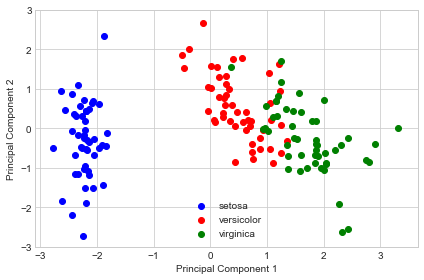

In [44]:
def showPCAReduction(s_matrix):
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(6,4))
        for label, color in zip(iris.target_names, ['blue', 'red', 'green']):
            plt.scatter(s_matrix[y==label, 0], s_matrix[y==label, 1], label=label, c=color)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(loc='lower center')
        plt.tight_layout()
        plt.show()

showPCAReduction(s)

## 4. PCA do scikit-learn

Podemos comparar nossos resultados utilizando a implementação presente na biblioteca scikit-learn.

In [45]:
from sklearn.decomposition import PCA as sklPCA
sklearn_pca = sklPCA(n_components=2)
y_sklearn = sklearn_pca.fit_transform(x_std)
print(y_sklearn.shape)

(150, 2)


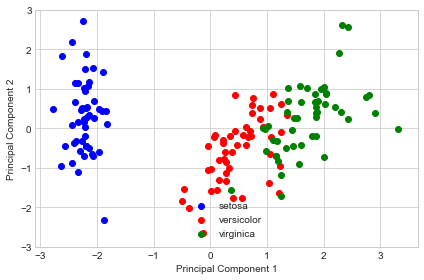

In [46]:
showPCAReduction(y_sklearn)

## 5. Regras Gerais

- **Sempre** normalize os atributos antes de aplicar o PCA (StandarScaler);
- Lembre-se de armazenar a média para efetuar a ida e volta;
- **Não** aplique o PCA após outros algoritmos de seleção de atributos;
- O número de componentes principais que você quer manter deve ser escolhido através da análise entre o número de componentes e a precisão do sistema. **Nem sempre mais componentes principais ocasionam em melhor precisão!**